In [48]:
import uproot as uproot# reading ROOT filies
import mplhep as hep # matplotlib for hep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import awkward as ak 

# path to the root files
path = '/work/projects/PHYS565/data/'

# configuration -- convention used, first sample is Data, the rest are MCs
filenames = ['data.root', 'wjets.root', 'dy.root',  'ttbar.root', 'ww.root',  'wz.root', 'zz.root', 'single_top.root', 'qcd.root']
labels = ['Data', 'WJets',   'DYJets', 'TTbar',   'WW',     'WZ',     'ZZ',      'Single Top','QCD']
colors = ["white","#79b278", "#f0f423", "#ff0000","#6b59d3", "orange", "#baff8d", "#00cdff"  , "#a9a9a9"]

TTreeName = 'events'
EventWeightBranchName = 'EventWeight' 

# set CMS plot style    
plt.style.use([hep.style.ROOT, hep.style.firamath])

# read all dataframes as awkward arrays https://awkward-array.readthedocs.io/en/stable/#    
dfs = [uproot.lazy(path+filename+':'+TTreeName) for filename in filenames]

# print out number of events found in each dataframe
for i in range(len(dfs)):
    if len(dfs) == len(labels) == len(colors):
        dfs[i].label = labels[i]
        dfs[i].color = colors[i]
        print('opened %s with %d entries as %s'%(filenames[i], len(dfs[i]), dfs[i].label))
    else: print('length of dfs, labels and colors are not equal, please fix and re-run')

opened data.root with 469384 entries as Data
opened wjets.root with 109737 entries as WJets
opened dy.root with 77729 entries as DYJets
opened ttbar.root with 36941 entries as TTbar
opened ww.root with 4580 entries as WW
opened wz.root with 3367 entries as WZ
opened zz.root with 2421 entries as ZZ
opened single_top.root with 5684 entries as Single Top
opened qcd.root with 142 entries as QCD


In [49]:
# reorder dataframes (optional) 
for i, df in enumerate(dfs):
    print('i = %d [%s]'%(i,df.label))

neworder = [0, 8, 1, 7, 4, 3, 5, 6, 2]

print('')
print('reordering dfs using these indexes', neworder)
print('')

reordered_dfs = [ dfs[neworder[i]] for i in range(len(dfs))]
for i, df in enumerate(reordered_dfs):
    print('i = %d [%s]'%(i,df.label))

# setting dfs to its new order
dfs = reordered_dfs

i = 0 [Data]
i = 1 [WJets]
i = 2 [DYJets]
i = 3 [TTbar]
i = 4 [WW]
i = 5 [WZ]
i = 6 [ZZ]
i = 7 [Single Top]
i = 8 [QCD]

reordering dfs using these indexes [0, 8, 1, 7, 4, 3, 5, 6, 2]

i = 0 [Data]
i = 1 [QCD]
i = 2 [WJets]
i = 3 [Single Top]
i = 4 [WW]
i = 5 [TTbar]
i = 6 [WZ]
i = 7 [ZZ]
i = 8 [DYJets]


In [50]:
#some pre analysis on the branches to be done 
dfs = [df.__setitem__('Muon_Py', ak.fill_none(ak.pad_none(df['Muon_Py'], 1, clip=True), 0)) or df for df in dfs]
dfs = [df.__setitem__('Muon_Px', ak.fill_none(ak.pad_none(df['Muon_Px'], 1, clip=True), 0)) or df for df in dfs]
dfs = [df.__setitem__('Muon_Pz', ak.fill_none(ak.pad_none(df['Muon_Pz'], 1, clip=True), 0)) or df for df in dfs]

In [51]:

def compute_selection(df, muon_pt_threshold=25, met_threshold=20, btag_threshold=0.679, muon_eta_max=2.5):
    
    # Compute leading muon pt
    muon_px = df["Muon_Px"][:, 0]
    muon_py = df["Muon_Py"][:, 0]
    muon_pz = df["Muon_Pz"][:, 0]
    #jet_px = df["Jet_Px"][:, 0]
    #jet_py = df["Jet_Py"][:, 0]
    #jet_pz = df["Jet_Pz"][:, 0]

    muon_pt = np.sqrt(muon_px**2 + muon_py**2 )
    #jet_pt = np.sqrt(jet_px**2 + jet_py**2 + jet_pz**2)

    # Compute MET
    met = np.sqrt(df["MET_px"]**2 + df["MET_py"]**2)

    # Compute number of b-tagged jets per event
    n_btagged = ak.sum(df["Jet_btag"] > btag_threshold, axis=1)

    offline_selection = (
        (df["NMuon"] == 1) &
        (met >= met_threshold) &
        (muon_pt >= muon_pt_threshold)&
        (df["NJet"] >= 4) &
        #(jet_pt >= 30) &
        (n_btagged >= 2)
    )

    trigger_passed = (df["triggerIsoMu24"] == 1)
    total_selection = offline_selection & trigger_passed

    return offline_selection, trigger_passed, total_selection, n_btagged


# Reweighting factor for b-tagged jets
def compute_reweighted_weights(df, n_btagged):
    return df["EventWeight"] * (0.855 ** n_btagged)


In [52]:
df_data=dfs[0]
df_QCD=dfs[1]
df_WJets=dfs[2]
df_ST=dfs[3]
df_WW=dfs[4]
df_ttbar=dfs[5]
df_WZ=dfs[6]
df_ZZ=dfs[7]
df_DYJ=dfs[8]


In [54]:
import awkward as ak
import numpy as np
from itertools import combinations

import awkward as ak
import numpy as np
from itertools import combinations

def invariant_mass(px, py, pz, E):
    mass_squared = E**2 - (px**2 + py**2 + pz**2)
    return np.sqrt(mass_squared) if mass_squared > 0 else 0

def chi2_metric(m_w_candidate, m_top_candidate, m_W=80.4, m_top=172.5, sigma_W=10, sigma_t=15):
    return ((m_w_candidate - m_W)**2 / sigma_W**2) + ((m_top_candidate - m_top)**2 / sigma_t**2)

def compute_mtop_hadronic_JES_JER(df, label="sample", jes_shift=0.0, jer_smear=0.0, btag_threshold=0.679):
    _, _, sel_mask, _ = compute_selection(df)
    df_sel = df[sel_mask]

    weights = df_sel["EventWeight"] if "EventWeight" in df_sel.fields else np.ones(len(df_sel))

    px = df_sel["Jet_Px"]
    py = df_sel["Jet_Py"]
    pz = df_sel["Jet_Pz"]
    E  = df_sel["Jet_E"]
    btag = df_sel["Jet_btag"]

    # Apply JES shift
    if jes_shift != 0.0:
        px = px*(1.0 + jes_shift)
        py = py*(1.0 + jes_shift)
        pz = pz*(1.0 + jes_shift)
        E  = E*(1.0 + jes_shift)

    # Apply JER smearing
    if jer_smear != 0.0:
        flat_px = ak.flatten(px)
        flat_py = ak.flatten(py)
        flat_pz = ak.flatten(pz)
        flat_E  = ak.flatten(E)

        smear_factors = np.random.normal(loc=1.0, scale=jer_smear, size=len(flat_px))
        flat_px = flat_px*smear_factors
        flat_py = flat_py*smear_factors
        flat_pz = flat_pz*smear_factors
        flat_E  = flat_E*smear_factors

        counts = ak.num(px)
        px = ak.unflatten(flat_px, counts)
        py = ak.unflatten(flat_py, counts)
        pz = ak.unflatten(flat_pz, counts)
        E  = ak.unflatten(flat_E, counts)

    mtop_candidates = []
    event_weights = []

    for evt in range(len(df_sel)):
        jets_btag = btag[evt]
        njets = len(jets_btag)
        jet_indices = np.arange(njets)

        bjets = jet_indices[jets_btag > btag_threshold]
        ljets = jet_indices[jets_btag <= btag_threshold]

        best_chi2 = np.inf
        best_mtop = None

        for i, j in combinations(ljets, 2):
            mjj = invariant_mass(px[evt][i] + px[evt][j], 
                                 py[evt][i] + py[evt][j], 
                                 pz[evt][i] + pz[evt][j], 
                                 E[evt][i]  + E[evt][j])

            for b in bjets:
                mtop = invariant_mass(
                    px[evt][i] + px[evt][j] + px[evt][b],
                    py[evt][i] + py[evt][j] + py[evt][b],
                    pz[evt][i] + pz[evt][j] + pz[evt][b],
                    E[evt][i]  + E[evt][j]  + E[evt][b]
                )

                chi2 = chi2_metric(mjj, mtop)
                if chi2 < best_chi2:
                    best_chi2 = chi2
                    best_mtop = mtop

        if best_mtop is not None:
            n_btagged = len(bjets)
            weight_reweighted = df_sel["EventWeight"][evt] * (0.9 ** n_btagged)
            mtop_candidates.append(best_mtop)
            event_weights.append(weight_reweighted)

    print(f"{label}: selected {len(mtop_candidates)} events (JES {jes_shift:+.1%}, JER {jer_smear:.1%})")
    return np.array(mtop_candidates), np.array(event_weights)

# =========================================
# Example usage
# =========================================

# Nominal
mtop_nominal = compute_mtop_hadronic_JES_JER(df_ttbar, label="Nominal")

# JES variations
mtop_JES_up   = compute_mtop_hadronic_JES_JER(df_ttbar, label="JES Up", jes_shift=+0.01)
mtop_JES_down = compute_mtop_hadronic_JES_JER(df_ttbar, label="JES Down", jes_shift=-0.01)

# JER variation
mtop_JER_up   = compute_mtop_hadronic_JES_JER(df_ttbar, label="JER Up", jer_smear=0.10)

# =========================================
# Compute mean shifts
# =========================================

mean_nominal = np.mean(mtop_nominal)
mean_JES_up  = np.mean(mtop_JES_up)
mean_JES_down= np.mean(mtop_JES_down)
mean_JER_up  = np.mean(mtop_JER_up)

delta_JES = max(abs(mean_JES_up - mean_nominal), abs(mean_JES_down - mean_nominal))
delta_JER = abs(mean_JER_up - mean_nominal)

# Combine systematics
total_systematic = np.sqrt(delta_JES**2 + delta_JER**2)

# =========================================
# Print summary
# =========================================

print("\n=== Hadronic Top Mass Systematic Uncertainty Results (Unified) ===\n")
print(f"Mean Top Mass (Nominal)    : {mean_nominal:.2f} GeV")
print(f"Shift JES (Up/Down)        : ±{delta_JES:.2f} GeV")
print(f"Shift JER (Smearing)       : ±{delta_JER:.2f} GeV")
print(f"\nTotal Systematic Uncertainty: ±{total_systematic:.2f} GeV")


Nominal: selected 477 events (JES +0.0%, JER 0.0%)
JES Up: selected 477 events (JES +1.0%, JER 0.0%)
JES Down: selected 477 events (JES -1.0%, JER 0.0%)
JER Up: selected 477 events (JES +0.0%, JER 10.0%)

=== Hadronic Top Mass Systematic Uncertainty Results (Unified) ===

Mean Top Mass (Nominal)    : 101.91 GeV
Shift JES (Up/Down)        : ±0.86 GeV
Shift JER (Smearing)       : ±0.35 GeV

Total Systematic Uncertainty: ±0.93 GeV


In [64]:
# =========================================
# Compute mean shifts
# =========================================

mean_nominal = np.mean(mtop_nominal[0])
mean_JES_up  = np.mean(mtop_JES_up[0])
mean_JES_down= np.mean(mtop_JES_down[0])
mean_JER_up  = np.mean(mtop_JER_up[0])

delta_JES = max(abs(mean_JES_up - mean_nominal), abs(mean_JES_down - mean_nominal))
delta_JER = abs(mean_JER_up - mean_nominal)

# Combine systematics
total_systematic = np.sqrt(delta_JES**2 + delta_JER**2)

# =========================================
# Print summary
# =========================================

print("\n=== Hadronic Top Mass Systematic Uncertainty Results (Unified) ===\n")
print(f"Mean Top Mass (Nominal)    : {mean_nominal:.2f} GeV")
print(f"Shift JES (Up/Down)        : ±{delta_JES:.2f} GeV")
print(f"Shift JER (Smearing)       : ±{delta_JER:.2f} GeV")
print(f"\nTotal Systematic Uncertainty: ±{total_systematic:.2f} GeV")



=== Hadronic Top Mass Systematic Uncertainty Results (Unified) ===

Mean Top Mass (Nominal)    : 203.64 GeV
Shift JES (Up/Down)        : ±1.71 GeV
Shift JER (Smearing)       : ±0.71 GeV

Total Systematic Uncertainty: ±1.85 GeV


In [61]:
np.mean(mtop_JES_up[0])

205.35377195235503

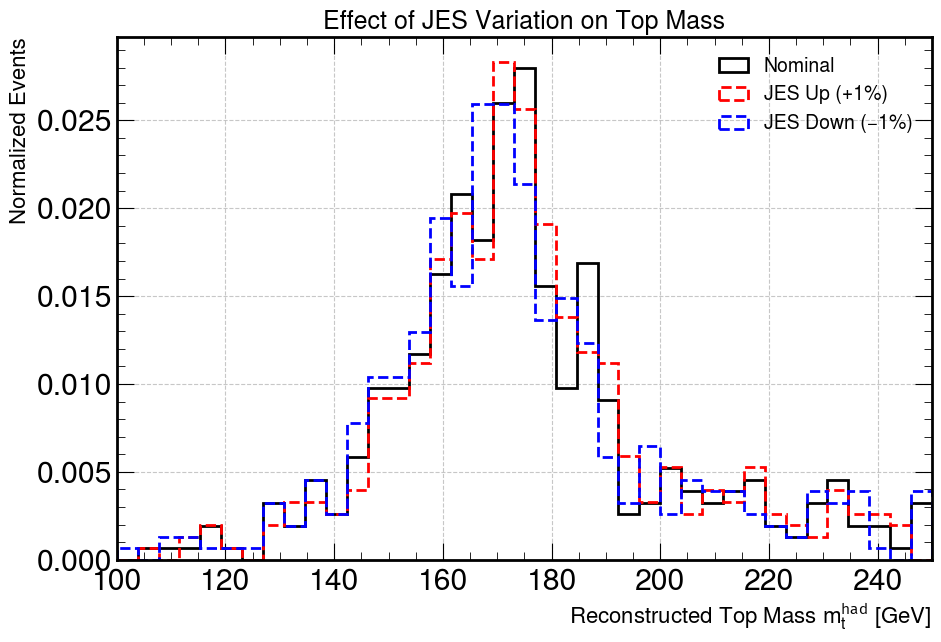

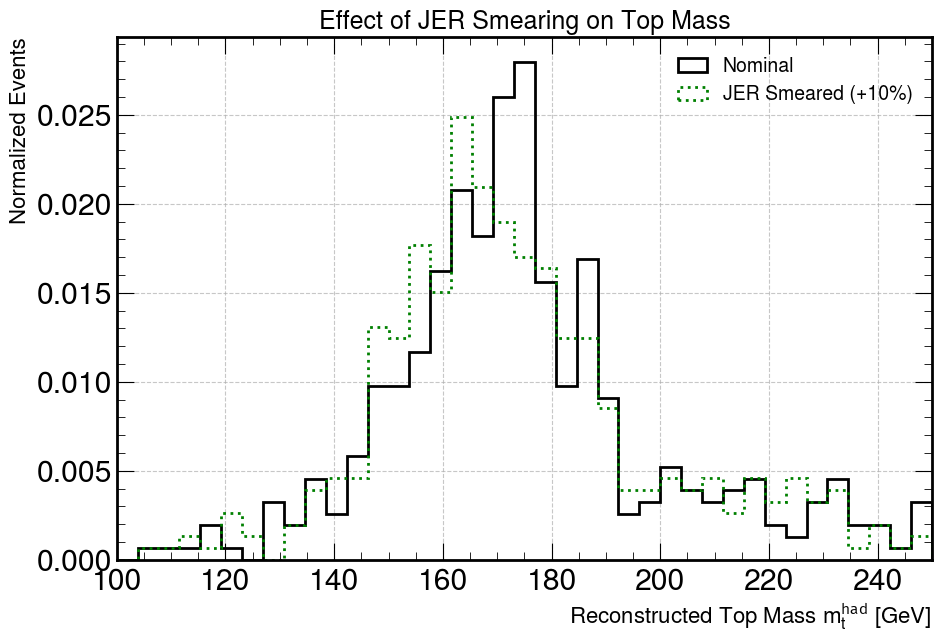

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you already have arrays:
# mtop_nominal, mtop_JES_up, mtop_JES_down, mtop_JER_up

# Define binning
bins = np.linspace(100, 250, 40)

# ===========================================
# Plot 1: JES Variations
# ===========================================
plt.figure(figsize=(10, 7))

plt.hist(mtop_nominal[0], bins=bins, histtype='step', linewidth=2, label='Nominal', color='black', density=True)
plt.hist(mtop_JES_up[0], bins=bins, histtype='step', linewidth=2, linestyle='--', label='JES Up (+1%)', color='red', density=True)
plt.hist(mtop_JES_down[0], bins=bins, histtype='step', linewidth=2, linestyle='--', label='JES Down (−1%)', color='blue', density=True)

plt.xlabel(r"Reconstructed Top Mass $m_{t}^{\text{had}}$ [GeV]", fontsize=16)
plt.ylabel("Normalized Events", fontsize=16)
plt.title("Effect of JES Variation on Top Mass", fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(100, 250)
plt.tight_layout()
plt.show()

# ===========================================
# Plot 2: JER Variation
# ===========================================
plt.figure(figsize=(10, 7))

plt.hist(mtop_nominal[0], bins=bins, histtype='step', linewidth=2, label='Nominal', color='black', density=True)
plt.hist(mtop_JER_up[0], bins=bins, histtype='step', linewidth=2, linestyle=':', label='JER Smeared (+10%)', color='green', density=True)

plt.xlabel(r"Reconstructed Top Mass $m_{t}^{\text{had}}$ [GeV]", fontsize=16)
plt.ylabel("Normalized Events", fontsize=16)
plt.title("Effect of JER Smearing on Top Mass", fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(100, 250)
plt.tight_layout()
plt.show()


In [78]:
import awkward as ak
import numpy as np
from itertools import combinations

# Invariant mass calculator
def invariant_mass(px, py, pz, E):
    mass_squared = E**2 - (px**2 + py**2 + pz**2)
    return np.sqrt(mass_squared) if mass_squared > 0 else 0

# Chi-square calculation for minimization
def chi2_metric(m_w_candidate, m_top_candidate, m_W=80.4, m_top=172.5, sigma_W=10, sigma_t=15):
    return ((m_w_candidate - m_W)**2 / sigma_W**2) + ((m_top_candidate - m_top)**2 / sigma_t**2)

# Scan b-tag threshold ±5% to assess variation
def compute_mtop_btag_threshold_variation(df, label="sample", return_weights=False, nominal_threshold=0.679):
    thresholds = {
        "down": nominal_threshold * 0.90,
        "nominal": nominal_threshold,
        "up": nominal_threshold * 1.10
    }

    results = {}

    for key, threshold in thresholds.items():
        _, _, sel_mask, _ = compute_selection(df)
        df_sel = df[sel_mask]

        weights = df_sel["EventWeight"] if "EventWeight" in df_sel.fields else np.ones(len(df_sel))

        px, py, pz, E, btag = (
            df_sel["Jet_Px"], df_sel["Jet_Py"], df_sel["Jet_Pz"], df_sel["Jet_E"], df_sel["Jet_btag"]
        )

        mtop_candidates, event_weights = [], []

        for evt in range(len(df_sel)):
            jets_btag = btag[evt]
            njets = len(jets_btag)
            jet_indices = np.arange(njets)

            bjets = jet_indices[jets_btag > threshold]
            ljets = jet_indices[jets_btag <= threshold]

            best_chi2 = np.inf
            best_mtop = None

            for i, j in combinations(ljets, 2):
                mjj = invariant_mass(px[evt][i] + px[evt][j],
                                     py[evt][i] + py[evt][j],
                                     pz[evt][i] + pz[evt][j],
                                     E[evt][i] + E[evt][j])

                for b in bjets:
                    mtop = invariant_mass(
                        px[evt][i] + px[evt][j] + px[evt][b],
                        py[evt][i] + py[evt][j] + py[evt][b],
                        pz[evt][i] + pz[evt][j] + pz[evt][b],
                        E[evt][i] + E[evt][j] + E[evt][b]
                    )

                    chi2 = chi2_metric(mjj, mtop)

                    if chi2 < best_chi2:
                        best_chi2 = chi2
                        best_mtop = mtop

            if best_mtop is not None:
                n_btagged = len(bjets)
                weight_reweighted = weights[evt] * (0.9 ** n_btagged)
                mtop_candidates.append(best_mtop)
                event_weights.append(weight_reweighted)

        print(f"{label} ({key}): selected {len(mtop_candidates)} events with b-tag threshold {threshold:.3f}")
        results[key] = (np.array(mtop_candidates), np.array(event_weights) if return_weights else None)

    return results


In [79]:
mtop_btag_var = compute_mtop_btag_threshold_variation(df_ttbar, label="TTbar", return_weights=True)


TTbar (down): selected 477 events with b-tag threshold 0.611
TTbar (nominal): selected 477 events with b-tag threshold 0.679
TTbar (up): selected 477 events with b-tag threshold 0.747


In [80]:
# Example access:
mass_nominal = mtop_btag_var["nominal"][0]
weight_nominal = mtop_btag_var["nominal"][1]

mass_up= mtop_btag_var["up"][0]
weight_up = mtop_btag_var["up"][1]

mass_down= mtop_btag_var["down"][0]
weight_down = mtop_btag_var["down"][1]

In [81]:
np.mean(mass_nominal)

203.64003537318135

In [82]:
np.mean(mass_up)

203.64003537318135

In [83]:
np.mean(mass_down)

203.64003537318135

In [84]:
import numpy as np
from scipy.optimize import curve_fit

# Define the Breit-Wigner function
def breit_wigner(m, m0, gamma):
    return 1 / ((m**2 - m0**2)**2 + m0**2 * gamma**2)

# Fit Breit-Wigner to weighted histograms
def fit_breit_wigner_with_weights(masses, weights, bins=40, range=(100, 300)):
    hist, bin_edges = np.histogram(masses, bins=bins, range=range, weights=weights)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    # Initial guesses: peak near 173, width around 20
    p0 = [173, 20]
    try:
        popt, pcov = curve_fit(breit_wigner, bin_centers, hist, p0=p0)
        m0, gamma = popt
        m0_err, gamma_err = np.sqrt(np.diag(pcov))
    except Exception as e:
        m0, gamma, m0_err, gamma_err = np.nan, np.nan, np.nan, np.nan
    return m0, m0_err

# Fit all three variations
mass_nominal, weight_nominal = mtop_btag_var["nominal"]
mass_up, weight_up = mtop_btag_var["up"]
mass_down, weight_down = mtop_btag_var["down"]

fit_nominal = fit_breit_wigner_with_weights(mass_nominal, weight_nominal)
fit_up = fit_breit_wigner_with_weights(mass_up, weight_up)
fit_down = fit_breit_wigner_with_weights(mass_down, weight_down)




In [85]:
fit_nominal

(167.49886042497806, 14695933.05696982)

In [86]:
fit_up

(167.49886042497806, 14695933.05696982)

In [87]:
import numpy as np
from itertools import combinations

# Modified compute_mtop_hadronic to include sf_btag
def compute_mtop_hadronic_scale(df, label="sample", return_weights=False, btag_threshold=0.679, sf_btag=0.90):
    _, _, sel_mask, _ = compute_selection(df)
    df_sel = df[sel_mask]

    weights = df_sel["EventWeight"] if "EventWeight" in df_sel.fields else np.ones(len(df_sel))

    px, py, pz, E, btag = (
        df_sel["Jet_Px"], df_sel["Jet_Py"], df_sel["Jet_Pz"], df_sel["Jet_E"], df_sel["Jet_btag"]
    )

    mtop_candidates, event_weights = [], []

    for evt in range(len(df_sel)):
        jets_btag = btag[evt]
        njets = len(jets_btag)
        jet_indices = np.arange(njets)

        bjets = jet_indices[jets_btag > btag_threshold]
        ljets = jet_indices[jets_btag <= btag_threshold]

        best_chi2 = np.inf
        best_mtop = None

        for i, j in combinations(ljets, 2):
            mjj = invariant_mass(px[evt][i] + px[evt][j],
                                 py[evt][i] + py[evt][j],
                                 pz[evt][i] + pz[evt][j],
                                 E[evt][i]  + E[evt][j])

            for b in bjets:
                mtop = invariant_mass(
                    px[evt][i] + px[evt][j] + px[evt][b],
                    py[evt][i] + py[evt][j] + py[evt][b],
                    pz[evt][i] + pz[evt][j] + pz[evt][b],
                    E[evt][i]  + E[evt][j]  + E[evt][b]
                )

                chi2 = chi2_metric(mjj, mtop)

                if chi2 < best_chi2:
                    best_chi2 = chi2
                    best_mtop = mtop

        if best_mtop is not None:
            n_btagged = len(bjets)
            weight_reweighted = df_sel["EventWeight"][evt] * (sf_btag ** n_btagged)
            mtop_candidates.append(best_mtop)
            event_weights.append(weight_reweighted)

    print(f"{label}: selected {len(mtop_candidates)} events using minimization")
    if return_weights:
        return np.array(mtop_candidates), np.array(event_weights)
    else:
        return np.array(mtop_candidates)



In [90]:
mt_nom_sf, w_nom_sf = compute_mtop_hadronic_scale(df_ttbar, label="SF=0.90", sf_btag=0.90, return_weights=True)
mt_up_sf,  w_up_sf  = compute_mtop_hadronic_scale(df_ttbar, label="SF=0.945", sf_btag=0.945, return_weights=True)
mt_down_sf, w_down_sf = compute_mtop_hadronic_scale(df_ttbar, label="SF=0.855", sf_btag=0.855, return_weights=True)

delta_m_btag_sf = max(abs(mt_up_sf.mean() - mt_nom_sf.mean()), abs(mt_down_sf.mean() - mt_nom_sf.mean()))


SF=0.90: selected 477 events using minimization
SF=0.945: selected 477 events using minimization
SF=0.855: selected 477 events using minimization


In [93]:
mt_nom_sf.mean()

203.64003537318135

In [95]:
mt_up_sf.mean()

203.64003537318135

In [91]:
delta_m_btag_sf

0.0

In [98]:
import numpy as np
import awkward as ak

def reconstruct_leptonic_top_masses_selected(df, label="sample",
                                               jer_smear=0.0,
                                               jes_shift=0.0,
                                               muon_pt_shift=0.0,
                                               met_shift=0.0,
                                               btag_threshold=0.679,
                                               sf_btag=0.90):
    """
    Leptonic top mass reconstruction with chi2 minimization and systematic variations.
    """
    _, _, selection, _ = compute_selection(df)
    df_sel = df[selection]

    mW = 80.4
    mu_mass = 0.105
    nu_mass = 0.0
    sigma_t = 15.0

    # Apply systematic variations
    mu_px = df_sel["Muon_Px"][:, 0] * (1 + muon_pt_shift)
    mu_py = df_sel["Muon_Py"][:, 0] * (1 + muon_pt_shift)
    mu_pz = df_sel["Muon_Pz"][:, 0] * (1 + muon_pt_shift)
    mu_e = np.sqrt(mu_px**2 + mu_py**2 + mu_pz**2 + mu_mass**2)

    met_px = df_sel["MET_px"] * (1 + met_shift)
    met_py = df_sel["MET_py"] * (1 + met_shift)

    jet_px = df_sel["Jet_Px"]
    jet_py = df_sel["Jet_Py"]
    jet_pz = df_sel["Jet_Pz"]
    jet_E  = df_sel["Jet_E"]
    jet_btag = df_sel["Jet_btag"]

    if jes_shift != 0.0:
        jet_px =jet_px* (1 + jes_shift)
        jet_py =jet_py* (1 + jes_shift)
        jet_pz =jet_pz* (1 + jes_shift)
        jet_E  =jet_E* (1 + jes_shift)

    if jer_smear > 0.0:
        counts = ak.num(jet_px)
        smear_factors = ak.unflatten(np.random.normal(1.0, jer_smear, ak.sum(counts)), counts)
        jet_px = jet_px*smear_factors
        jet_py = jet_py*smear_factors
        jet_pz = jet_pz*smear_factors
        jet_E  = jet_E*smear_factors

    leptonic_top_masses = []
    leptonic_weights = []

    for i in range(len(df_sel)):
        if len(jet_px[i]) == 0:
            continue

        bjets_idx = np.where(jet_btag[i] > btag_threshold)[0]
        if len(bjets_idx) == 0:
            continue

        best_chi2 = np.inf
        best_mtop = None

        for bidx in bjets_idx:
            b_px = jet_px[i][bidx]
            b_py = jet_py[i][bidx]
            b_pz = jet_pz[i][bidx]
            b_e  = jet_E[i][bidx]

            # solve quadratic for neutrino pz
            a = 4 * (mu_e[i]**2 - mu_pz[i]**2)
            b = 4 * mu_pz[i] * (mW**2 - 2 * (mu_px[i]*met_px[i] + mu_py[i]*met_py[i]))
            c = (mW**2 - 2 * (mu_px[i]*met_px[i] + mu_py[i]*met_py[i]))**2 - 4 * mu_e[i]**2 * (met_px[i]**2 + met_py[i]**2)

            disc = b**2 - 4*a*c
            if disc < 0:
                continue

            sqrt_disc = np.sqrt(disc)
            for pz_nu in [(-b + sqrt_disc) / (2*a), (-b - sqrt_disc) / (2*a)]:
                e_nu = np.sqrt(met_px[i]**2 + met_py[i]**2 + pz_nu**2 + nu_mass**2)

                top_px = mu_px[i] + met_px[i] + b_px
                top_py = mu_py[i] + met_py[i] + b_py
                top_pz = mu_pz[i] + pz_nu + b_pz
                top_e  = mu_e[i] + e_nu + b_e

                m_top = np.sqrt(top_e**2 - top_px**2 - top_py**2 - top_pz**2)
                chi2 = ((m_top - 172.5)**2) / sigma_t**2

                if chi2 < best_chi2:
                    best_chi2 = chi2
                    best_mtop = m_top

        if best_mtop is not None:
            n_btagged = np.sum(jet_btag[i] > btag_threshold)
            weight = df_sel["EventWeight"][i] * (sf_btag ** n_btagged) if "EventWeight" in df_sel.fields else (sf_btag ** n_btagged)
            leptonic_top_masses.append(best_mtop)
            leptonic_weights.append(weight)

    print(f"{label}: selected {len(leptonic_top_masses)} events with chi2 and reweighting")
    return np.array(leptonic_top_masses), np.array(leptonic_weights)


In [99]:
# Nominal
mtop_lep_nominal, _ = reconstruct_leptonic_top_masses_selected(df_ttbar, label="Nominal")

# JES Up/Down
mtop_lep_JESup, _ = reconstruct_leptonic_top_masses_selected(df_ttbar, label="JES Up", jes_shift=+0.01)
mtop_lep_JESdown,_ = reconstruct_leptonic_top_masses_selected(df_ttbar, label="JES Down", jes_shift=-0.01)

# JER Up
mtop_lep_JERup, _ = reconstruct_leptonic_top_masses_selected(df_ttbar, label="JER Smeared", jer_smear=0.10)

# Muon Scale Up/Down
mtop_lep_muonup, _ = reconstruct_leptonic_top_masses_selected(df_ttbar, label="Muon Scale Up", muon_pt_shift=+0.01)
mtop_lep_muondown,_= reconstruct_leptonic_top_masses_selected(df_ttbar, label="Muon Scale Down", muon_pt_shift=-0.01)

# MET Scale Up/Down
mtop_lep_METup, _ = reconstruct_leptonic_top_masses_selected(df_ttbar, label="MET Scale Up", met_shift=+0.01)
mtop_lep_METdown,_= reconstruct_leptonic_top_masses_selected(df_ttbar, label="MET Scale Down", met_shift=-0.01)

# (Optional) vary b-tag threshold if needed



Nominal: selected 405 events with chi2 and reweighting
JES Up: selected 405 events with chi2 and reweighting
JES Down: selected 405 events with chi2 and reweighting
JER Smeared: selected 405 events with chi2 and reweighting
Muon Scale Up: selected 408 events with chi2 and reweighting
Muon Scale Down: selected 404 events with chi2 and reweighting
MET Scale Up: selected 408 events with chi2 and reweighting
MET Scale Down: selected 404 events with chi2 and reweighting


In [100]:
import numpy as np

# 1. Compute means
mean_lep_nominal  = np.mean(mtop_lep_nominal)
mean_lep_JESup    = np.mean(mtop_lep_JESup)
mean_lep_JESdown  = np.mean(mtop_lep_JESdown)
mean_lep_JERup    = np.mean(mtop_lep_JERup)
mean_lep_muonup   = np.mean(mtop_lep_muonup)
mean_lep_muondown = np.mean(mtop_lep_muondown)
mean_lep_METup    = np.mean(mtop_lep_METup)
mean_lep_METdown  = np.mean(mtop_lep_METdown)

# 2. Calculate shifts individually
delta_lep_JES = max(abs(mean_lep_JESup - mean_lep_nominal), abs(mean_lep_JESdown - mean_lep_nominal))
delta_lep_JER = abs(mean_lep_JERup - mean_lep_nominal)
delta_lep_Muon = max(abs(mean_lep_muonup - mean_lep_nominal), abs(mean_lep_muondown - mean_lep_nominal))
delta_lep_MET  = max(abs(mean_lep_METup - mean_lep_nominal), abs(mean_lep_METdown - mean_lep_nominal))

# 3. Add 1 GeV manually for neutrino pz solving uncertainty
delta_lep_NeutrinoMethod = 1.0

# 4. Print systematics
print("\n=== Individual Leptonic Top Mass Systematics ===\n")
print(f"JES Systematic        : ±{delta_lep_JES:.2f} GeV")
print(f"JER Systematic        : ±{delta_lep_JER:.2f} GeV")
print(f"Muon Scale Systematic : ±{delta_lep_Muon:.2f} GeV")
print(f"MET Scale Systematic  : ±{delta_lep_MET:.2f} GeV")
#print(f"Neutrino Method Bias  : ±{delta_lep_NeutrinoMethod:.2f} GeV")

# 5. Combine all systematics in quadrature
total_lep_systematic_uncertainty = np.sqrt(
    delta_lep_JES**2 +
    delta_lep_JER**2 +
    delta_lep_Muon**2 +
    delta_lep_MET**2 
    #delta_lep_NeutrinoMethod**2
)

print("\n=== Total Systematic Uncertainty on Leptonic Top Mass ===\n")
print(f"Total Systematic      : ±{total_lep_systematic_uncertainty:.2f} GeV")



=== Individual Leptonic Top Mass Systematics ===

JES Systematic        : ±0.32 GeV
JER Systematic        : ±0.96 GeV
Muon Scale Systematic : ±0.29 GeV
MET Scale Systematic  : ±0.26 GeV

=== Total Systematic Uncertainty on Leptonic Top Mass ===

Total Systematic      : ±1.08 GeV


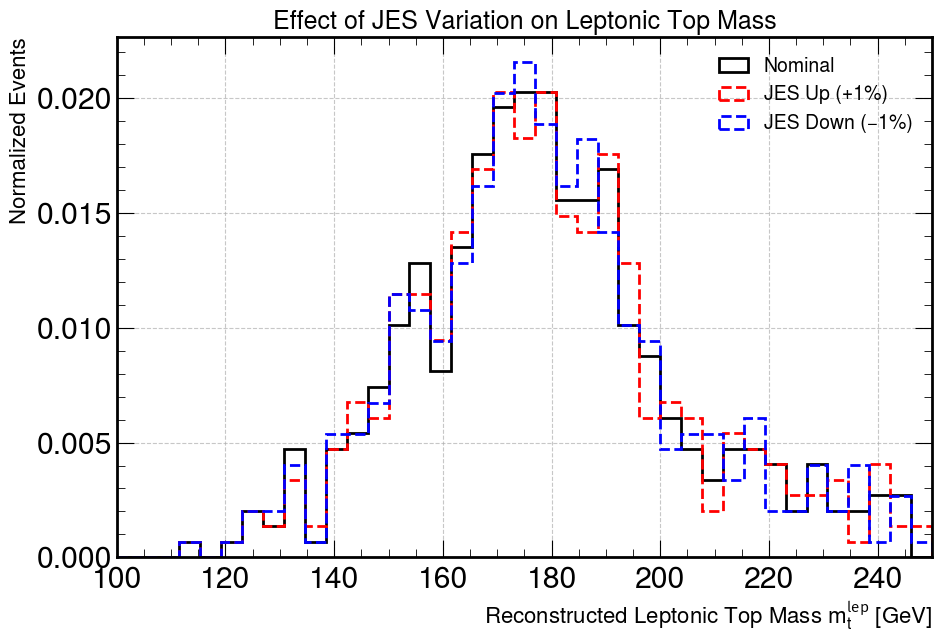

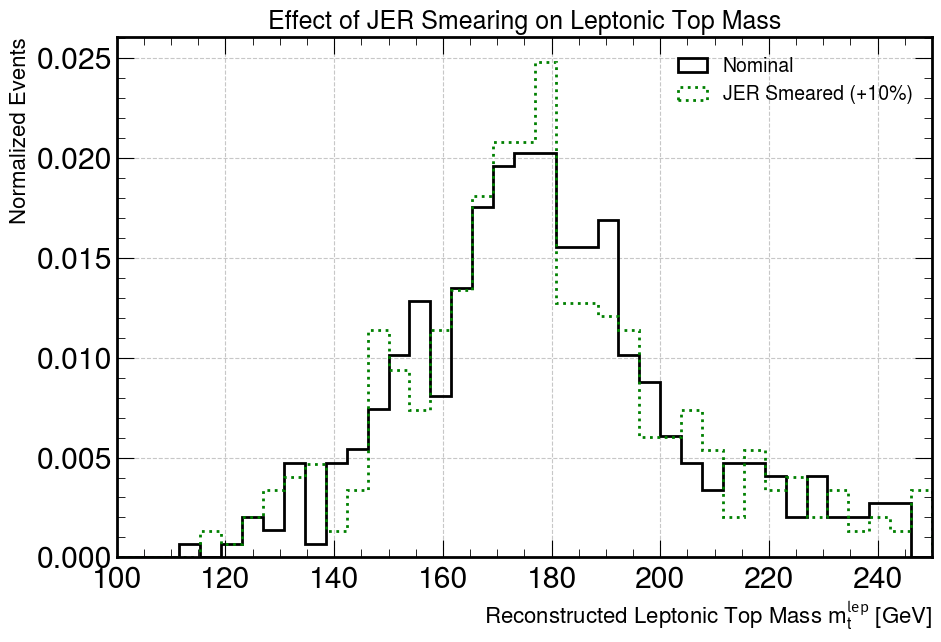

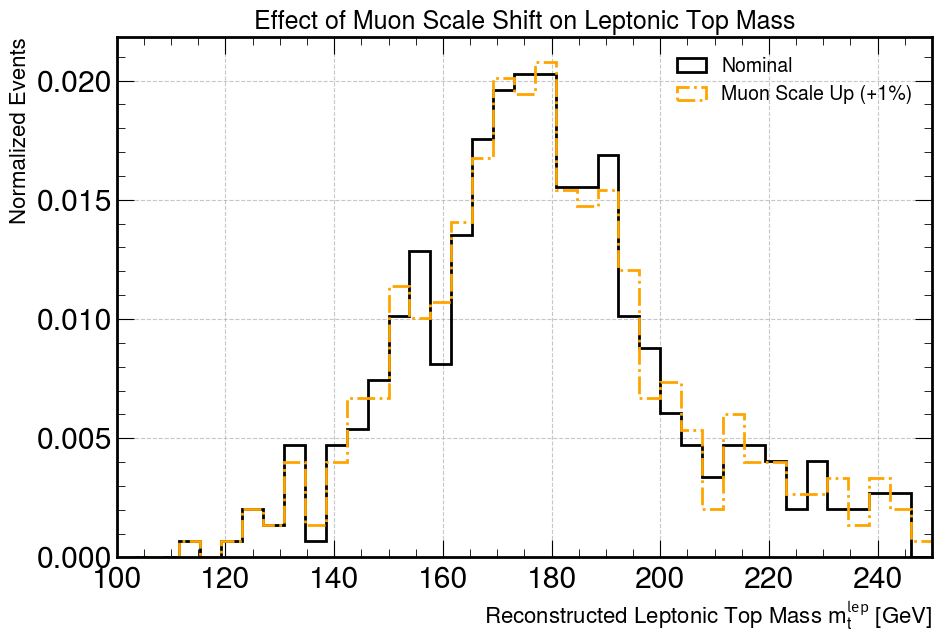

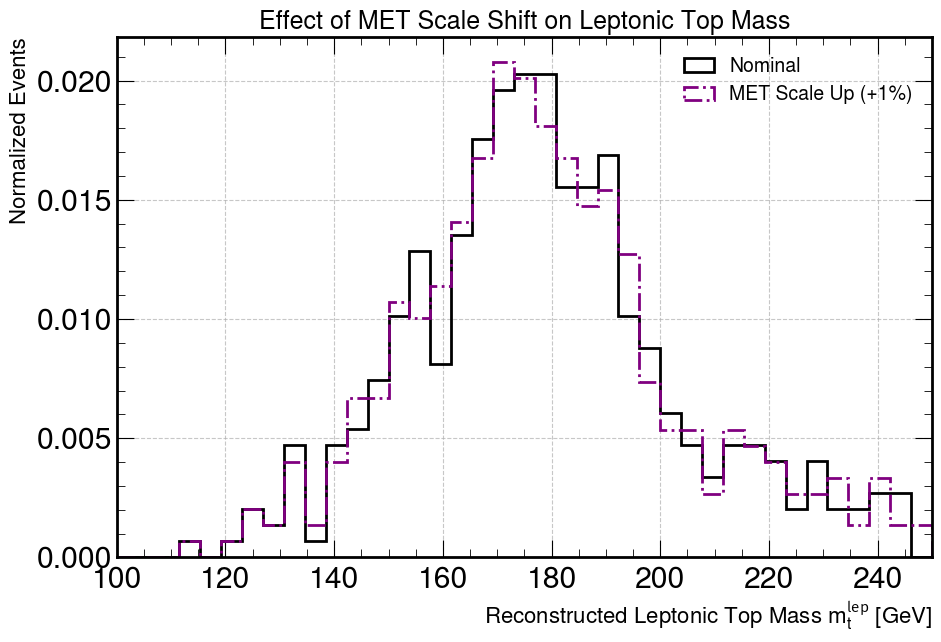

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you have all arrays ready:
# mtop_lep_nominal, mtop_lep_JESup, mtop_lep_JESdown, mtop_lep_JERup, mtop_lep_muonup, mtop_lep_METup

# Define common binning
bins = np.linspace(100, 250, 40)

# ============================================================
# Plot 1: JES Variations
# ============================================================
plt.figure(figsize=(10, 7))

plt.hist(mtop_lep_nominal, bins=bins, histtype='step', linewidth=2, label='Nominal', color='black', density=True)
plt.hist(mtop_lep_JESup, bins=bins, histtype='step', linewidth=2, linestyle='--', label='JES Up (+1%)', color='red', density=True)
plt.hist(mtop_lep_JESdown, bins=bins, histtype='step', linewidth=2, linestyle='--', label='JES Down (−1%)', color='blue', density=True)

plt.xlabel(r"Reconstructed Leptonic Top Mass $m_{t}^{\text{lep}}$ [GeV]", fontsize=16)
plt.ylabel("Normalized Events", fontsize=16)
plt.title("Effect of JES Variation on Leptonic Top Mass", fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(100, 250)
plt.tight_layout()
plt.show()

# ============================================================
# Plot 2: JER Variation
# ============================================================
plt.figure(figsize=(10, 7))

plt.hist(mtop_lep_nominal, bins=bins, histtype='step', linewidth=2, label='Nominal', color='black', density=True)
plt.hist(mtop_lep_JERup, bins=bins, histtype='step', linewidth=2, linestyle=':', label='JER Smeared (+10%)', color='green', density=True)

plt.xlabel(r"Reconstructed Leptonic Top Mass $m_{t}^{\text{lep}}$ [GeV]", fontsize=16)
plt.ylabel("Normalized Events", fontsize=16)
plt.title("Effect of JER Smearing on Leptonic Top Mass", fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(100, 250)
plt.tight_layout()
plt.show()

# ============================================================
# Plot 3: Muon Scale Variation
# ============================================================
plt.figure(figsize=(10, 7))

plt.hist(mtop_lep_nominal, bins=bins, histtype='step', linewidth=2, label='Nominal', color='black', density=True)
plt.hist(mtop_lep_muonup, bins=bins, histtype='step', linewidth=2, linestyle='-.', label='Muon Scale Up (+1%)', color='orange', density=True)

plt.xlabel(r"Reconstructed Leptonic Top Mass $m_{t}^{\text{lep}}$ [GeV]", fontsize=16)
plt.ylabel("Normalized Events", fontsize=16)
plt.title("Effect of Muon Scale Shift on Leptonic Top Mass", fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(100, 250)
plt.tight_layout()
plt.show()

# ============================================================
# Plot 4: MET Scale Variation
# ============================================================
plt.figure(figsize=(10, 7))

plt.hist(mtop_lep_nominal, bins=bins, histtype='step', linewidth=2, label='Nominal', color='black', density=True)
plt.hist(mtop_lep_METup, bins=bins, histtype='step', linewidth=2, linestyle='-.', label='MET Scale Up (+1%)', color='purple', density=True)

plt.xlabel(r"Reconstructed Leptonic Top Mass $m_{t}^{\text{lep}}$ [GeV]", fontsize=16)
plt.ylabel("Normalized Events", fontsize=16)
plt.title("Effect of MET Scale Shift on Leptonic Top Mass", fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(100, 250)
plt.tight_layout()
plt.show()


In [102]:
import numpy as np

def reconstruct_leptonic_top_masses_and_weights_with_systematics(df, label="sample", btag_threshold=0.679):
    _, _, selection, _ = compute_selection(df)
    df_sel = df[selection]

    mW = 80.4  # W boson mass in GeV
    mu_mass = 0.105
    nu_mass = 0.0

    masses_min_abs, weights_min_abs = [], []
    masses_max_abs, weights_max_abs = [], []

    for i in range(len(df_sel["Muon_Px"])):
        if len(df_sel["Muon_Px"][i]) == 0 or len(df_sel["Jet_Px"][i]) == 0:
            continue

        mu_px = df_sel["Muon_Px"][i][0]
        mu_py = df_sel["Muon_Py"][i][0]
        mu_pz = df_sel["Muon_Pz"][i][0]
        mu_e = np.sqrt(mu_px**2 + mu_py**2 + mu_pz**2 + mu_mass**2)

        met_px = df_sel["MET_px"][i]
        met_py = df_sel["MET_py"][i]

        a = 4 * (mu_e**2 - mu_pz**2)
        b = 4 * mu_pz * (mW**2 - 2 * (mu_px * met_px + mu_py * met_py))
        c = (mW**2 - 2 * (mu_px * met_px + mu_py * met_py))**2 - 4 * mu_e**2 * (met_px**2 + met_py**2)

        discriminant = b**2 - 4*a*c
        if discriminant < 0:
            continue

        sqrt_disc = np.sqrt(discriminant)
        pz_nu_1 = (-b + sqrt_disc) / (2*a)
        pz_nu_2 = (-b - sqrt_disc) / (2*a)
        neutrino_solutions = [pz_nu_1, pz_nu_2]

        best_mtop_min_abs, best_chi2_min_abs = None, np.inf
        best_mtop_max_abs, best_chi2_max_abs = None, np.inf

        for pz_nu in neutrino_solutions:
            e_nu = np.sqrt(met_px**2 + met_py**2 + pz_nu**2 + nu_mass**2)

            for bidx in range(len(df_sel["Jet_Px"][i])):
                b_px = df_sel["Jet_Px"][i][bidx]
                b_py = df_sel["Jet_Py"][i][bidx]
                b_pz = df_sel["Jet_Pz"][i][bidx]
                b_e = df_sel["Jet_E"][i][bidx]

                top_px = mu_px + met_px + b_px
                top_py = mu_py + met_py + b_py
                top_pz = mu_pz + pz_nu + b_pz
                top_e = mu_e + e_nu + b_e

                m_top = np.sqrt(top_e**2 - top_px**2 - top_py**2 - top_pz**2)
                chi2 = ((m_top - 172.5)**2) / (15**2)

                if abs(pz_nu) == min(abs(pz_nu_1), abs(pz_nu_2)) and chi2 < best_chi2_min_abs:
                    best_chi2_min_abs = chi2
                    best_mtop_min_abs = m_top

                if abs(pz_nu) == max(abs(pz_nu_1), abs(pz_nu_2)) and chi2 < best_chi2_max_abs:
                    best_chi2_max_abs = chi2
                    best_mtop_max_abs = m_top

        if best_mtop_min_abs is not None:
            n_btagged = np.sum(df_sel["Jet_btag"][i] > btag_threshold)
            weight = df_sel["EventWeight"][i] * (0.9 ** n_btagged) if "EventWeight" in df_sel.fields else (0.9 ** n_btagged)
            masses_min_abs.append(best_mtop_min_abs)
            weights_min_abs.append(weight)

        if best_mtop_max_abs is not None:
            n_btagged = np.sum(df_sel["Jet_btag"][i] > btag_threshold)
            weight = df_sel["EventWeight"][i] * (0.9 ** n_btagged) if "EventWeight" in df_sel.fields else (0.9 ** n_btagged)
            masses_max_abs.append(best_mtop_max_abs)
            weights_max_abs.append(weight)

    print(f"{label}: selected {len(masses_min_abs)} events (min abs pz), {len(masses_max_abs)} events (max abs pz)")
    return {
        "min_abs": (np.array(masses_min_abs), np.array(weights_min_abs)),
        "max_abs": (np.array(masses_max_abs), np.array(weights_max_abs))
    }


In [103]:
result = reconstruct_leptonic_top_masses_and_weights_with_systematics(df_ttbar, label="leptonic")
mass_min_abs, weight_min_abs = result["min_abs"]
mass_max_abs, weight_max_abs = result["max_abs"]


leptonic: selected 405 events (min abs pz), 405 events (max abs pz)


In [109]:
# Weighted means
mean_min_abs = np.average(mass_min_abs, weights=weight_min_abs)
mean_max_abs = np.average(mass_max_abs, weights=weight_max_abs)

In [110]:
mean_min_abs

193.77816553477928

In [111]:
mean_max_abs

287.5376433314548

In [112]:
# Compute systematic uncertainty from pz choice as half the absolute difference
delta_pz_choice = 0.5 * abs(mean_min_abs - mean_max_abs)
delta_pz_choice

46.87973889833775